In [1]:
from torch.utils.data import Dataset, DataLoader
import json
from torchvision import transforms, utils
from PIL import Image 
import random
import torch
import torch.nn as nn
import numpy as np
import torchvision.utils as vutils
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models

## Evaluator

In [2]:
'''===============================================================
1. Title:     

DLP spring 2022 Lab7 classifier

2. Purpose:

For computing the classification accruacy.

3. Details:

The model is based on ResNet18 with only chaning the
last linear layer. The model is trained on iclevr dataset
with 1 to 5 objects and the resolution is the upsampled 
64x64 images from 32x32 images.

It will capture the top k highest accuracy indexes on generated
images and compare them with ground truth labels.

4. How to use

You should call eval(images, labels) and to get total accuracy.
images shape: (batch_size, 3, 64, 64)
labels shape: (batch_size, 24) where labels are one-hot vectors
e.g. [[1,1,0,...,0],[0,1,1,0,...],...]

==============================================================='''


class evaluation_model():
    def __init__(self):
        #modify the path to your own path
        checkpoint = torch.load('checkpoint.pth')
        self.resnet18 = models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Sequential(
            nn.Linear(512,24),
            nn.Sigmoid()
        )
        self.resnet18.load_state_dict(checkpoint['model'])
        self.resnet18 = self.resnet18.cuda()
        self.resnet18.eval()
        self.classnum = 24
    def compute_acc(self, out, onehot_labels):
        batch_size = out.size(0)
        acc = 0
        total = 0
        for i in range(batch_size):
            k = int(onehot_labels[i].sum().item())
            total += k
            outv, outi = out[i].topk(k)
            lv, li = onehot_labels[i].topk(k)
            for j in outi:
                if j in li:
                    acc += 1
        return acc / total
    def eval(self, images, labels):
        with torch.no_grad():
            #your image shape should be (batch, 3, 64, 64)
            out = self.resnet18(images)
            acc = self.compute_acc(out.cpu(), labels.cpu())
            return acc

# Custumized Dataset

In [3]:
def one_hot(dictionary,labels):
    one_hot_vector = []
    for _ in range(len(dictionary)):
        one_hot_vector.append(0)
    
    for label in labels:
        one_hot_vector[dictionary[label]] = 1
    
    return torch.FloatTensor(one_hot_vector)

class Lab7Dataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.image = []
        self.label = []
        
        object_json = open('objects.json')
        self.object_dict = json.load(object_json)
        train_json = open('train.json')
        train_dict = json.load(train_json)
        
        for key, value in train_dict.items():
            path = root+'/'+str(key)
            pre_img = Image.open(path)             
            pre_img = pre_img.resize((64,64), Image.ANTIALIAS)
            transformation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean = (0.5, 0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5, 0.5))
            ])
            img = transformation(pre_img)
            img = img[:3]
            
            self.image.append(img)
            self.label.append(value)
            
    def __getitem__(self, index):
        return self.image[index], one_hot(self.object_dict , self.label[index])
            
    def __len__(self):
        return len(self.label)

## Network

In [4]:
class NETG(nn.Module):
    def __init__(self,nz,nclass,nc):
        super(NETG, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz + nclass, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
    def forward(self, x, label,nclass):
        label = label.view(-1, nclass, 1, 1)
        x = torch.cat([x, label], 1)
        return self.net(x)


class NETD(nn.Module):
    def __init__(self,nc,nclass):
        super(NETD, self).__init__()
        self.feature_input = nn.Linear(nclass, 64 * 64)
        self.net = nn.Sequential(
            nn.Conv2d(nc + 1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )
    def forward(self, x, attr):
        attr = self.feature_input(attr).view(-1, 1, 64, 64)
        x = torch.cat([x, attr], 1)
        return self.net(x).view(-1, 1)

## Train and Test

In [5]:
def train_and_test(train_loader,netG,optimizerG,netD,optimizerD,eval_model,hyperparameter,device):
    #train
    tensor = {}
    tensor["noise"] = torch.FloatTensor(hyperparameter['batch_size'], hyperparameter['nz'], 1, 1).to(device)
    tensor["label_real"] = torch.FloatTensor(hyperparameter['batch_size'], 1).fill_(1).to(device)
    tensor["label_fake"] = torch.FloatTensor(hyperparameter['batch_size'], 1).fill_(0).to(device)
    
    #test
    test_label=[]
    test_json = open('test.json')
    test_dict = json.load(test_json)
    for pre_label in test_dict:
        label = one_hot(train_loader.dataset.object_dict , pre_label)
        test_label.append(label.tolist())
        
    #new_test    
    new_test_label=[]
    new_test_json = open('new_test.json')
    new_test_dict = json.load(new_test_json)
    for pre_label in new_test_dict:
        label = one_hot(train_loader.dataset.object_dict , pre_label)
        new_test_label.append(label.tolist())
    
    epoch_max=0
    test_max=0
    new_test_max=0
    test_score_list=[]
    new_test_score_list=[]
    for epoch_i in range(hyperparameter['epochs']):
        train(train_loader,netG,optimizerG,netD,optimizerD,hyperparameter,tensor,device)
        test_score,new_test_score,fake_test_data,new_fake_test_data = test(epoch_i,train_loader,netG,netD,eval_model,hyperparameter,tensor,test_label,new_test_label,device,test_max,new_test_max,epoch_max)
        test_score_list.append(test_score)
        new_test_score_list.append(new_test_score)
        epoch_max,test_max,new_test_max = save_model(netG,netD,test_max,new_test_max,test_score,new_test_score,fake_test_data,new_fake_test_data,epoch_max,epoch_i)
    print("-------------------")
    print("Best epoch : ", epoch_max)
    print("Result:")
    print("Best test.json score : ", test_max)
    print("Best new_test.json score : ", new_test_max)
    score_list=[test_score_list,new_test_score_list]
    name_list=['test.json','new_test.json']
    color=['b','g']
    title='Score - Epoch Graph'
    draw_score_graph(score_list, name_list, color, title, hyperparameter['epochs'])
    
def train(train_loader,netG,optimizerG,netD,optimizerD,hyperparameter,tensor,device):
    netG.train()
    netD.train()
    Loss = nn.MSELoss()
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        optimizerD.zero_grad()
        
        if data.size(0) !=hyperparameter['batch_size']:
            continue
        
        tensor['noise'].data.resize_(data.size(0), hyperparameter['nz'], 1, 1).normal_(0, 1)
        
        prediction_real = netD(data, label)
        fake_data = netG(tensor['noise'], label,hyperparameter['nclass']) 
        prediction_fake = netD(fake_data.detach(), label)
        
        netD_loss = Loss(prediction_real, tensor['label_real']) + Loss(prediction_fake, tensor['label_fake'])
        netD_loss.backward()
        optimizerD.step()
        
        optimizerG.zero_grad()
        prediction_fake = netD(fake_data, label)
        netG_loss = Loss(prediction_fake, tensor['label_real'])
        netG_loss.backward()
        optimizerG.step()
        
def test(epoch_i,train_loader,netG,netD,eval_model,hyperparameter,tensor,test_label_list,new_test_label_list,device,test_max,new_test_max,epoch_max):
    netG.eval()
    netD.eval()
    test_label = torch.FloatTensor(test_label_list).to(device)
    new_test_label = torch.FloatTensor(new_test_label_list).to(device)
    
    tensor['noise'].data.resize_(hyperparameter['batch_size'], hyperparameter['nz'], 1, 1).normal_(0, 1)
    
    fake_test_data = netG(tensor['noise'], test_label,hyperparameter['nclass'])
    test_score = eval_model.eval(fake_test_data, test_label)
    new_fake_test_data = netG(tensor['noise'], new_test_label,hyperparameter['nclass'])
    new_test_score = eval_model.eval(new_fake_test_data, new_test_label)
    
    print("Epoch: " + str(epoch_i) + ", Test score: " + str(test_score))
    print("Epoch: " + str(epoch_i) + ", New test score: " + str(new_test_score))    
    
    vutils.save_image(fake_test_data.data, '{}/epoch_{:03d}.png'.format("output_image_ver4", epoch_i ), normalize=True)
    vutils.save_image(new_fake_test_data, '{}/epoch_{:03d}.png'.format("new_output_image_ver4", epoch_i ), normalize=True)
    
    return test_score,new_test_score,fake_test_data,new_fake_test_data

## Draw Score Graph

In [6]:
def draw_score_graph(acc_list, name_list, color, title, epoch_num):
    epoch = range(epoch_num)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    for acc_list_idx , name_list_idx ,color_idx in zip(acc_list, name_list, color):
        plt.plot(epoch, acc_list_idx, color_idx, label=name_list_idx)
    plt.legend()
    plt.show()

## Save Model

In [7]:
def save_model(netG,netD,test_max,new_test_max,test_score,new_test_score,fake_test_data,new_fake_test_data,epoch_max,epoch_i):
    if (test_max<=test_score) and (new_test_max<=new_test_score):
        test_max = test_score
        new_test_max = new_test_score
        epoch_max = epoch_i
        torch.save(netD.state_dict(), 'netD_ver4.pkl')
        torch.save(netG.state_dict(), 'netG_ver4.pkl')
        vutils.save_image(fake_test_data.data, '{}/epoch_{}.png'.format("output_image_ver4", 'best' ), normalize=True)
        vutils.save_image(new_fake_test_data, '{}/epoch_{}.png'.format("new_output_image_ver4", 'best' ), normalize=True)
        
    else:
        max_grade = calculate_grade(test_max) + calculate_grade(new_test_max)
        score_grade = calculate_grade(test_score) + calculate_grade(new_test_score)
        if(max_grade<score_grade):
            test_max = test_score
            new_test_max = new_test_score
            epoch_max = epoch_i
            torch.save(netD.state_dict(), 'netD_ver4.pkl')
            torch.save(netG.state_dict(), 'netG_ver4.pkl')
            vutils.save_image(fake_test_data.data, '{}/epoch_{}.png'.format("output_image_ver4", 'best' ), normalize=True)
            vutils.save_image(new_fake_test_data, '{}/epoch_{}.png'.format("new_output_image_ver4", 'best' ), normalize=True)
    
    return epoch_max,test_max,new_test_max

    
def calculate_grade(score):
    if score>=0.8:
        return 1.0
    elif score>=0.7:
        return 0.9
    elif score>=0.6:
        return 0.8
    elif score>=0.5:
        return 0.7
    elif score>=0.4:
        return 0.6
    else:
        return 0.0

## Main

In [8]:
def main():
    hyperparameter={}
    hyperparameter['lrG'] = 5e-4
    hyperparameter['lrD'] = 3e-5
    hyperparameter['batch_size'] = 32
    hyperparameter['nz'] = 25
    hyperparameter['nclass'] = 24
    hyperparameter['nc'] = 3
    hyperparameter['beta'] = (0.5, 0.999)
    hyperparameter['epochs'] = 1000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Load Data...")
    Dataset = Lab7Dataset("iclevr")
    train_loader = DataLoader(dataset=Dataset, batch_size=hyperparameter['batch_size'], shuffle=True)
    
    print("Initialize Network And Optimizer")
    netG = NETG(hyperparameter['nz'] ,hyperparameter['nclass'] ,hyperparameter['nc'] ).to(device)
    optimizerG = optim.Adam(netG.parameters(), lr = hyperparameter['lrG'], betas = hyperparameter['beta'])
    netD = NETD(hyperparameter['nc'],hyperparameter['nclass']).to(device)
    optimizerD = optim.Adam(netD.parameters(), lr = hyperparameter['lrD'], betas = hyperparameter['beta'])
    
    eval_model = evaluation_model()
    print('Train Model')
    train_and_test(train_loader,netG,optimizerG,netD,optimizerD,eval_model,hyperparameter,device)

Load Data...
Initialize Network And Optimizer
Train Model
Epoch: 0, Test score: 0.09722222222222222
Epoch: 0, New test score: 0.14285714285714285
Epoch: 1, Test score: 0.1111111111111111
Epoch: 1, New test score: 0.11904761904761904
Epoch: 2, Test score: 0.1111111111111111
Epoch: 2, New test score: 0.11904761904761904
Epoch: 3, Test score: 0.1111111111111111
Epoch: 3, New test score: 0.09523809523809523
Epoch: 4, Test score: 0.1527777777777778
Epoch: 4, New test score: 0.10714285714285714
Epoch: 5, Test score: 0.1111111111111111
Epoch: 5, New test score: 0.19047619047619047
Epoch: 6, Test score: 0.08333333333333333
Epoch: 6, New test score: 0.2261904761904762
Epoch: 7, Test score: 0.16666666666666666
Epoch: 7, New test score: 0.21428571428571427
Epoch: 8, Test score: 0.1388888888888889
Epoch: 8, New test score: 0.17857142857142858
Epoch: 9, Test score: 0.1388888888888889
Epoch: 9, New test score: 0.2261904761904762
Epoch: 10, Test score: 0.2361111111111111
Epoch: 10, New test score: 0.

Epoch: 95, Test score: 0.5833333333333334
Epoch: 95, New test score: 0.6666666666666666
Epoch: 96, Test score: 0.625
Epoch: 96, New test score: 0.6547619047619048
Epoch: 97, Test score: 0.6666666666666666
Epoch: 97, New test score: 0.6309523809523809
Epoch: 98, Test score: 0.6111111111111112
Epoch: 98, New test score: 0.6547619047619048
Epoch: 99, Test score: 0.5694444444444444
Epoch: 99, New test score: 0.6785714285714286
Epoch: 100, Test score: 0.6388888888888888
Epoch: 100, New test score: 0.6428571428571429
Epoch: 101, Test score: 0.6388888888888888
Epoch: 101, New test score: 0.6547619047619048
Epoch: 102, Test score: 0.5694444444444444
Epoch: 102, New test score: 0.6904761904761905
Epoch: 103, Test score: 0.6527777777777778
Epoch: 103, New test score: 0.6547619047619048
Epoch: 104, Test score: 0.5694444444444444
Epoch: 104, New test score: 0.6785714285714286
Epoch: 105, Test score: 0.5972222222222222
Epoch: 105, New test score: 0.6428571428571429
Epoch: 106, Test score: 0.5833333

Epoch: 189, Test score: 0.5972222222222222
Epoch: 189, New test score: 0.5833333333333334
Epoch: 190, Test score: 0.6666666666666666
Epoch: 190, New test score: 0.75
Epoch: 191, Test score: 0.6944444444444444
Epoch: 191, New test score: 0.6547619047619048
Epoch: 192, Test score: 0.5972222222222222
Epoch: 192, New test score: 0.7023809523809523
Epoch: 193, Test score: 0.6666666666666666
Epoch: 193, New test score: 0.7142857142857143
Epoch: 194, Test score: 0.6527777777777778
Epoch: 194, New test score: 0.6428571428571429
Epoch: 195, Test score: 0.5555555555555556
Epoch: 195, New test score: 0.6547619047619048
Epoch: 196, Test score: 0.6666666666666666
Epoch: 196, New test score: 0.75
Epoch: 197, Test score: 0.625
Epoch: 197, New test score: 0.6547619047619048
Epoch: 198, Test score: 0.6111111111111112
Epoch: 198, New test score: 0.7142857142857143
Epoch: 199, Test score: 0.5694444444444444
Epoch: 199, New test score: 0.6547619047619048
Epoch: 200, Test score: 0.6388888888888888
Epoch: 2

Epoch: 282, Test score: 0.6111111111111112
Epoch: 282, New test score: 0.6785714285714286
Epoch: 283, Test score: 0.6388888888888888
Epoch: 283, New test score: 0.6904761904761905
Epoch: 284, Test score: 0.6944444444444444
Epoch: 284, New test score: 0.6904761904761905
Epoch: 285, Test score: 0.5833333333333334
Epoch: 285, New test score: 0.6904761904761905
Epoch: 286, Test score: 0.6527777777777778
Epoch: 286, New test score: 0.7142857142857143
Epoch: 287, Test score: 0.6388888888888888
Epoch: 287, New test score: 0.7142857142857143
Epoch: 288, Test score: 0.6388888888888888
Epoch: 288, New test score: 0.6904761904761905
Epoch: 289, Test score: 0.7083333333333334
Epoch: 289, New test score: 0.6428571428571429
Epoch: 290, Test score: 0.625
Epoch: 290, New test score: 0.6785714285714286
Epoch: 291, Test score: 0.6527777777777778
Epoch: 291, New test score: 0.6904761904761905
Epoch: 292, Test score: 0.6527777777777778
Epoch: 292, New test score: 0.6666666666666666
Epoch: 293, Test score:

Epoch: 377, Test score: 0.6944444444444444
Epoch: 377, New test score: 0.6785714285714286
Epoch: 378, Test score: 0.6527777777777778
Epoch: 378, New test score: 0.7380952380952381
Epoch: 379, Test score: 0.7361111111111112
Epoch: 379, New test score: 0.7023809523809523
Epoch: 380, Test score: 0.625
Epoch: 380, New test score: 0.7142857142857143
Epoch: 381, Test score: 0.6388888888888888
Epoch: 381, New test score: 0.7380952380952381
Epoch: 382, Test score: 0.6527777777777778
Epoch: 382, New test score: 0.7619047619047619
Epoch: 383, Test score: 0.6944444444444444
Epoch: 383, New test score: 0.6428571428571429
Epoch: 384, Test score: 0.6805555555555556
Epoch: 384, New test score: 0.75
Epoch: 385, Test score: 0.6666666666666666
Epoch: 385, New test score: 0.6904761904761905
Epoch: 386, Test score: 0.7083333333333334
Epoch: 386, New test score: 0.7023809523809523
Epoch: 387, Test score: 0.625
Epoch: 387, New test score: 0.75
Epoch: 388, Test score: 0.6527777777777778
Epoch: 388, New test 

Epoch: 472, Test score: 0.5833333333333334
Epoch: 472, New test score: 0.7142857142857143
Epoch: 473, Test score: 0.6944444444444444
Epoch: 473, New test score: 0.7142857142857143
Epoch: 474, Test score: 0.6527777777777778
Epoch: 474, New test score: 0.75
Epoch: 475, Test score: 0.7361111111111112
Epoch: 475, New test score: 0.6785714285714286
Epoch: 476, Test score: 0.625
Epoch: 476, New test score: 0.8095238095238095
Epoch: 477, Test score: 0.6111111111111112
Epoch: 477, New test score: 0.7380952380952381
Epoch: 478, Test score: 0.6666666666666666
Epoch: 478, New test score: 0.7619047619047619
Epoch: 479, Test score: 0.6527777777777778
Epoch: 479, New test score: 0.7261904761904762
Epoch: 480, Test score: 0.6666666666666666
Epoch: 480, New test score: 0.75
Epoch: 481, Test score: 0.6944444444444444
Epoch: 481, New test score: 0.7380952380952381
Epoch: 482, Test score: 0.6805555555555556
Epoch: 482, New test score: 0.7261904761904762
Epoch: 483, Test score: 0.6527777777777778
Epoch: 4

Epoch: 566, Test score: 0.6666666666666666
Epoch: 566, New test score: 0.7857142857142857
Epoch: 567, Test score: 0.625
Epoch: 567, New test score: 0.75
Epoch: 568, Test score: 0.6111111111111112
Epoch: 568, New test score: 0.75
Epoch: 569, Test score: 0.6666666666666666
Epoch: 569, New test score: 0.7142857142857143
Epoch: 570, Test score: 0.625
Epoch: 570, New test score: 0.7380952380952381
Epoch: 571, Test score: 0.6527777777777778
Epoch: 571, New test score: 0.7738095238095238
Epoch: 572, Test score: 0.6527777777777778
Epoch: 572, New test score: 0.7976190476190477
Epoch: 573, Test score: 0.7222222222222222
Epoch: 573, New test score: 0.7380952380952381
Epoch: 574, Test score: 0.6805555555555556
Epoch: 574, New test score: 0.7380952380952381
Epoch: 575, Test score: 0.6805555555555556
Epoch: 575, New test score: 0.7380952380952381
Epoch: 576, Test score: 0.6944444444444444
Epoch: 576, New test score: 0.7619047619047619
Epoch: 577, Test score: 0.7777777777777778
Epoch: 577, New test 

Epoch: 661, Test score: 0.6388888888888888
Epoch: 661, New test score: 0.7261904761904762
Epoch: 662, Test score: 0.625
Epoch: 662, New test score: 0.7142857142857143
Epoch: 663, Test score: 0.7222222222222222
Epoch: 663, New test score: 0.7380952380952381
Epoch: 664, Test score: 0.6111111111111112
Epoch: 664, New test score: 0.7380952380952381
Epoch: 665, Test score: 0.6805555555555556
Epoch: 665, New test score: 0.75
Epoch: 666, Test score: 0.6111111111111112
Epoch: 666, New test score: 0.7261904761904762
Epoch: 667, Test score: 0.6944444444444444
Epoch: 667, New test score: 0.7619047619047619
Epoch: 668, Test score: 0.6666666666666666
Epoch: 668, New test score: 0.7142857142857143
Epoch: 669, Test score: 0.8333333333333334
Epoch: 669, New test score: 0.7857142857142857
Epoch: 670, Test score: 0.6666666666666666
Epoch: 670, New test score: 0.75
Epoch: 671, Test score: 0.6944444444444444
Epoch: 671, New test score: 0.7738095238095238
Epoch: 672, Test score: 0.7638888888888888
Epoch: 6

Epoch: 755, Test score: 0.6666666666666666
Epoch: 755, New test score: 0.7261904761904762
Epoch: 756, Test score: 0.6666666666666666
Epoch: 756, New test score: 0.6428571428571429
Epoch: 757, Test score: 0.6666666666666666
Epoch: 757, New test score: 0.75
Epoch: 758, Test score: 0.625
Epoch: 758, New test score: 0.7023809523809523
Epoch: 759, Test score: 0.7222222222222222
Epoch: 759, New test score: 0.7738095238095238
Epoch: 760, Test score: 0.6111111111111112
Epoch: 760, New test score: 0.6547619047619048
Epoch: 761, Test score: 0.75
Epoch: 761, New test score: 0.7738095238095238
Epoch: 762, Test score: 0.7083333333333334
Epoch: 762, New test score: 0.7261904761904762
Epoch: 763, Test score: 0.6666666666666666
Epoch: 763, New test score: 0.75
Epoch: 764, Test score: 0.6944444444444444
Epoch: 764, New test score: 0.7976190476190477
Epoch: 765, Test score: 0.7638888888888888
Epoch: 765, New test score: 0.7023809523809523
Epoch: 766, Test score: 0.6666666666666666
Epoch: 766, New test s

Epoch: 850, Test score: 0.6944444444444444
Epoch: 850, New test score: 0.7261904761904762
Epoch: 851, Test score: 0.6388888888888888
Epoch: 851, New test score: 0.75
Epoch: 852, Test score: 0.7083333333333334
Epoch: 852, New test score: 0.7738095238095238
Epoch: 853, Test score: 0.7083333333333334
Epoch: 853, New test score: 0.6547619047619048
Epoch: 854, Test score: 0.7083333333333334
Epoch: 854, New test score: 0.7261904761904762
Epoch: 855, Test score: 0.6388888888888888
Epoch: 855, New test score: 0.75
Epoch: 856, Test score: 0.6666666666666666
Epoch: 856, New test score: 0.7142857142857143
Epoch: 857, Test score: 0.7361111111111112
Epoch: 857, New test score: 0.7738095238095238
Epoch: 858, Test score: 0.6805555555555556
Epoch: 858, New test score: 0.7023809523809523
Epoch: 859, Test score: 0.6944444444444444
Epoch: 859, New test score: 0.7380952380952381
Epoch: 860, Test score: 0.6805555555555556
Epoch: 860, New test score: 0.7738095238095238
Epoch: 861, Test score: 0.722222222222

Epoch: 944, Test score: 0.6527777777777778
Epoch: 944, New test score: 0.7976190476190477
Epoch: 945, Test score: 0.7361111111111112
Epoch: 945, New test score: 0.7142857142857143
Epoch: 946, Test score: 0.7222222222222222
Epoch: 946, New test score: 0.7023809523809523
Epoch: 947, Test score: 0.6805555555555556
Epoch: 947, New test score: 0.7261904761904762
Epoch: 948, Test score: 0.7777777777777778
Epoch: 948, New test score: 0.7261904761904762
Epoch: 949, Test score: 0.6805555555555556
Epoch: 949, New test score: 0.7619047619047619
Epoch: 950, Test score: 0.6527777777777778
Epoch: 950, New test score: 0.6785714285714286
Epoch: 951, Test score: 0.7083333333333334
Epoch: 951, New test score: 0.7857142857142857
Epoch: 952, Test score: 0.6805555555555556
Epoch: 952, New test score: 0.7261904761904762
Epoch: 953, Test score: 0.7222222222222222
Epoch: 953, New test score: 0.7380952380952381
Epoch: 954, Test score: 0.6111111111111112
Epoch: 954, New test score: 0.75
Epoch: 955, Test score: 

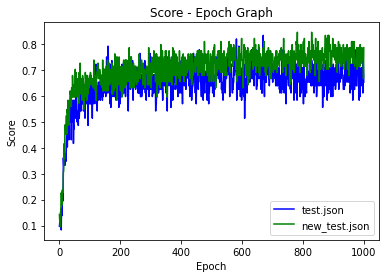

In [9]:
if __name__ == "__main__":
    main()